## Lab 04 Rozpoznawanie wzorców


**Zadanie** 
Pracujecie w starej fabryce ubrań, gdzie kamery pozostawiają wiele do życzenia. Zaproponujcie metodę detekcji ubrań na palecie 3x3 ubrań a następnie klasyfikacji, jeśli miejsce nie jest puste.
Obrazy monochromatyczne (F-MNIST)

- Przygotować 3 zbiorcze zdjęcia testowe złożone z losowych przykładów zbioru F-MNIST. Siatka 3x3, w
dwóch zdjęciach mają być braki,
- Zaproponować metodę detekcji "czy miejsce w siatce jest pustce" i oznaczyć je przy pomocy Bounding
Boxa (Bbox).
- Z pomocą dowolnych metod przeprowadzić klasyfikację co najmniej 1 wykrytego obiektu, pozostałe
oznaczyć jako "Towar".
15


### Importy

In [2]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## 1. Wczytywanie i rysowanie

In [3]:
transform = transforms.Compose([transforms.ToTensor()])

fmnist = datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=transform
)

classes = fmnist.classes

In [4]:
def create_fmnist_grid(dataset, n_rows=3, n_cols=3, n_empty=3):
    total_cells = n_rows * n_cols

    empty_indices = random.sample(range(total_cells), n_empty)

    images = []
    labels = []

    for i in range(total_cells):
        if i in empty_indices:
            images.append(torch.ones((1, 28, 28)))
            labels.append(None)
        else:
            idx = random.randint(0, len(dataset) - 1)
            img, label = dataset[idx]

            img = 1 - img
            images.append(img)
            labels.append(classes[label])

    return images, labels


def plot_fmnist_grid(images, labels, n_rows=3, n_cols=3, figsize=(6, 6)):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)

    if n_rows * n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1 or n_cols == 1:
        axes = np.array(axes).reshape(n_rows, n_cols)

    for i, ax in enumerate(axes.flat):
        img = images[i].squeeze()
        if isinstance(img, torch.Tensor):
            img = img.numpy()

        ax.imshow(img, cmap="gray", vmin=0, vmax=1)

        if labels[i] is None:
            ax.set_title("", fontsize=8, color="red")
        else:
            ax.set_title(labels[i], fontsize=8)

        ax.axis("off")

    plt.tight_layout()
    plt.show()


In [5]:
def create_palette(images, n_rows=3, n_cols=3):
    rows = []
    for i in range(n_rows):
        row_imgs = []
        for j in range(n_cols):
            idx = i * n_cols + j
            img = images[idx].squeeze()
            if isinstance(img, torch.Tensor):
                img = img.numpy()
            row_imgs.append(img)
        row_concat = np.hstack(row_imgs)
        rows.append(row_concat)
    palette = np.vstack(rows)
    return palette

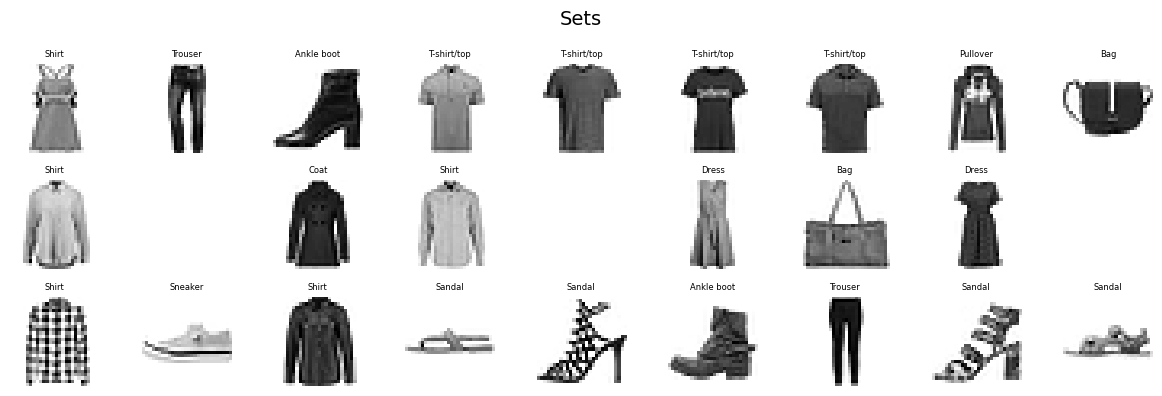

In [6]:
grids = []
for i in range(3):
    if i == 1:
        images, labels = create_fmnist_grid(fmnist, n_empty=3)
    else:
        images, labels = create_fmnist_grid(fmnist, n_empty=0)
    grids.append((images, labels))

fig, axes = plt.subplots(3, 9, figsize=(12, 4))

axes = axes.reshape(3, 9)

for col, (images, labels) in enumerate(grids):
    for i, ax in enumerate(axes[col]):
        img = images[i].squeeze().numpy()
        ax.imshow(img, cmap="gray", vmin=0, vmax=1)

        if labels[i] is None:
            ax.set_title("", fontsize=6, color="red")
        else:
            ax.set_title(labels[i], fontsize=6)

        ax.axis("off")
        ax.set_facecolor("white")

plt.suptitle("Sets", fontsize=14)
plt.tight_layout()
plt.show()

## 2. Wykrywanie bounding box

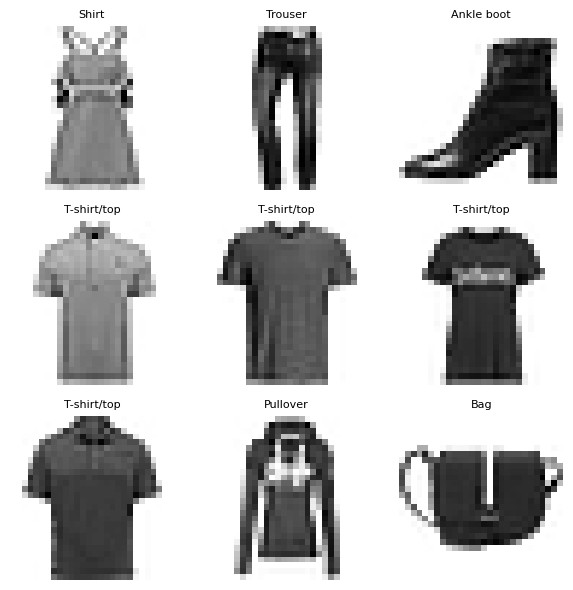

In [7]:
ex_image = grids[0][0]
ex_labels = grids[0][1]

plot_fmnist_grid(ex_image, ex_labels)

**Pomysł**

1) Dla każdego zdjęcia liczymy gradienty
2) Jeśli gradient > threshold -> mamy krawędź
3) Oznaczamy jako bounding box

In [8]:
def calculate_gradient(img: np.array):
    grad_x = np.zeros_like(img)
    grad_x[:, :-1] = img[:, 1:] - img[:, :-1]

    grad_y = np.zeros_like(img)
    grad_y[:-1, :] = img[1:, :] - img[:-1, :]

    grad_mag = np.sqrt(grad_x**2 + grad_y**2)
    grad_mag = (grad_mag - grad_mag.min()) / (grad_mag.max() - grad_mag.min())  # norm

    return grad_mag


def detect_bounds(
    grad: np.array, threshold: float = 0.5
):  # return mask, if el is 1 it means that high gradient
    result = grad > threshold
    return result

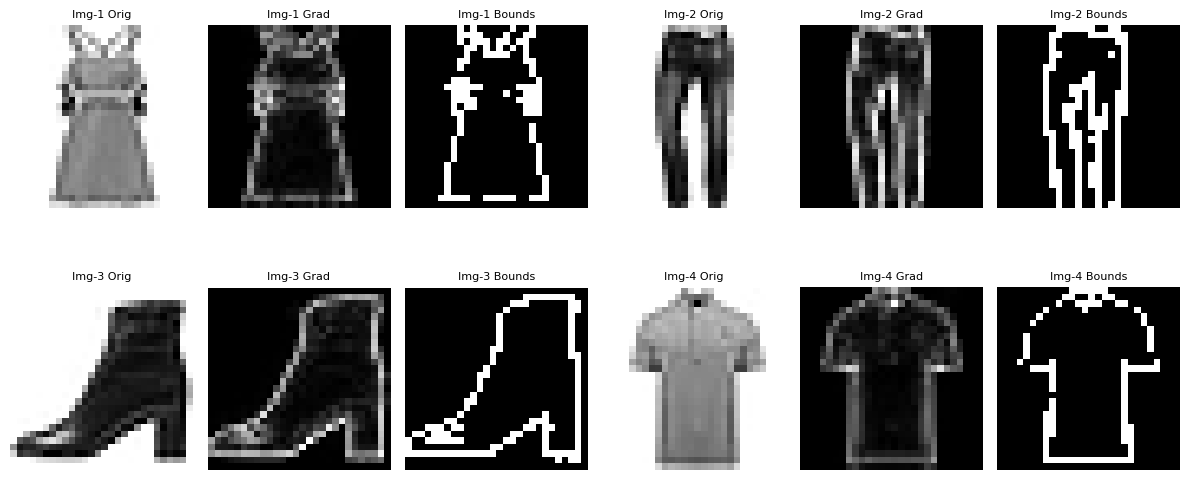

In [17]:
all_images = []
all_labels = []

for i in range(4):
    img_tensor = grids[0][0][i]
    img = img_tensor.squeeze().numpy()
    all_images.append(img)
    all_labels.append(f"Img-{i + 1} Orig")

    grad_mag = calculate_gradient(img)
    all_images.append(grad_mag)
    all_labels.append(f"Img-{i + 1} Grad")

    bounds = detect_bounds(grad_mag, threshold=0.3)
    bounds_img = bounds.astype(float)
    all_images.append(bounds_img)
    all_labels.append(f"Img-{i + 1} Bounds")


plot_fmnist_grid(all_images, all_labels, n_rows=2, n_cols=6, figsize=(12, 6))

### Wykrywanie czy miejsce jest puste

Założenie:
- znamy rozmiar elementu na palecie (rozmiar obrazka)
- paleta jest zawsze 3x3
- dodatkowo, elementy na palecie mają numeracje (poniżej pokazana)

```python
[
    [1, 2, 3], 
    [4, 5, 6], 
    [7, 8, 9]
]
```


Plan:
- wykrywamy krawędzie dla każdego elementu (wiemy gdzie leżą bo znamy rozmiar)
- przykładamy kownolucje o rozmiarze obrazka do bounding boxes, liczymy średnią
- jeśli przekroczy ustaloną wartość, to mamy towar
- w przeciwnym wypadku jest pusto


Zwracamy macierz True/False, tam gdzie NIE puste jest True.

In [10]:
fmnist_size = 28


def detect_objects(palette: np.array, detect_threshold: float = 0.5, img_threshold=0.5):
    res = np.zeros((3, 3), dtype=bool)

    for i in range(3):
        for j in range(3):
            sub_img = palette[
                i * fmnist_size : (i + 1) * fmnist_size,
                j * fmnist_size : (j + 1) * fmnist_size,
            ]

            grad_mag = calculate_gradient(sub_img)
            bounds = detect_bounds(grad_mag, threshold=detect_threshold)
            res[i, j] = bounds.mean() > img_threshold

    return res

### Przkład działania 1

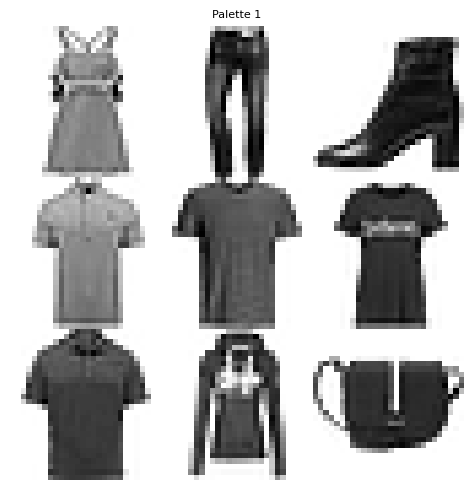

[[ True  True  True]
 [ True  True  True]
 [ True  True  True]]


In [11]:
palette1 = grids[0][0]
palette1_lb = grids[0][1]
palette1_img = create_palette(palette1)

plot_fmnist_grid([palette1_img], ["Palette 1"], n_rows=1, n_cols=1, figsize=(5, 5))
detected1 = detect_objects(palette1_img, detect_threshold=0.3, img_threshold=0.1)
print(detected1)


Warto zwrócić uwagę na parametry, detect_threshold=0.3, img_threshold=0.1. Przy ich niewłaściwym dobraniu nie zadziała. detect_threshold jest niższy niż poprzednio. Wole mieć grubsez krawędzie, niż za małe..

### Przykład 2

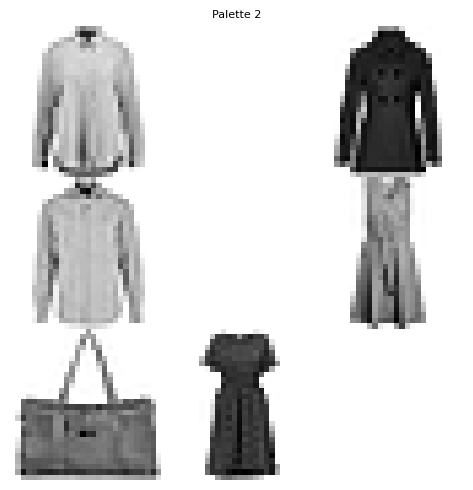

[[False False  True]
 [ True False  True]
 [ True  True False]]


/tmp/ipykernel_9177/1434050666.py:9: RuntimeWarning: invalid value encountered in divide
  grad_mag = (grad_mag - grad_mag.min()) / (grad_mag.max() - grad_mag.min())  # norm


In [12]:
palette2 = grids[1][0]
palette2_lb = grids[1][1]
palette2_img = create_palette(palette2)

plot_fmnist_grid([palette2_img], ["Palette 2"], n_rows=1, n_cols=1, figsize=(5, 5))
detected2 = detect_objects(palette2_img, detect_threshold=0.3, img_threshold=0.1)
print(detected2)


### Przykład 3

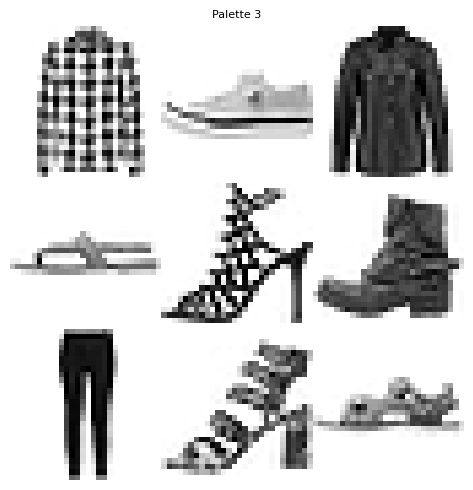

[[ True  True  True]
 [ True  True  True]
 [ True  True  True]]


In [13]:
palette3 = grids[2][0]
palette3_lb = grids[2][1]
palette3_img = create_palette(palette3)

plot_fmnist_grid([palette3_img], ["Palette 3"], n_rows=1, n_cols=1, figsize=(5, 5))
detected3 = detect_objects(palette3_img, detect_threshold=0.3, img_threshold=0.1)
print(detected3)


## Wykrywanie obiketów

Modyfikacja powyżej metody: Zamiast True/False będziemy wypisywać nazwe obiektu jaki się znajduje na obrazku.

Pomysł na model

1) Parsujemy wszystki obrazki na obrazki "krawędzi".
2) Uczymy SVM'a do klasyfikacji klas na krawędziach.
3) Thresholdy ustawione jak w przykładach.

### Tworzenie datasetu

In [18]:
X = []
y = []

for img_tensor, label in fmnist:
    img = img_tensor.squeeze().numpy()
    grad_mag = calculate_gradient(img)
    bounds = detect_bounds(grad_mag, threshold=0.3)
    X.append(bounds.flatten())
    y.append(label)

X = np.array(X)
y = np.array(y)

X_train, X_eval, y_train, y_eval = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


print(f"X_train.shape={X_train.shape}")

X_train.shape=(48000, 784)


### Trening

In [19]:
from sklearn.svm import LinearSVC

svm = LinearSVC(C=1.0, max_iter=5000, tol=1e-4, verbose=1)
svm.fit(X_train, y_train)

[LibLinear]iter  1 act 3.630e+04 pre 3.532e+04 delta 2.478e-01 f 4.800e+04 |g| 3.908e+05 CG   2
cg reaches trust region boundary
iter  2 act 3.528e+03 pre 3.135e+03 delta 2.853e-01 f 1.170e+04 |g| 4.323e+04 CG   4
cg reaches trust region boundary
iter  3 act 1.099e+03 pre 9.837e+02 delta 3.403e-01 f 8.173e+03 |g| 1.896e+04 CG   5
cg reaches trust region boundary
iter  4 act 4.550e+02 pre 3.866e+02 delta 4.312e-01 f 7.074e+03 |g| 7.852e+03 CG   6
cg reaches trust region boundary
iter  5 act 2.145e+02 pre 1.934e+02 delta 4.918e-01 f 6.619e+03 |g| 3.978e+03 CG   8
cg reaches trust region boundary
iter  6 act 7.691e+01 pre 7.026e+01 delta 5.357e-01 f 6.404e+03 |g| 1.814e+03 CG  12
cg reaches trust region boundary
iter  7 act 2.702e+01 pre 2.609e+01 delta 5.641e-01 f 6.327e+03 |g| 3.568e+02 CG  16
cg reaches trust region boundary
iter  8 act 1.402e+01 pre 1.378e+01 delta 5.835e-01 f 6.300e+03 |g| 2.716e+02 CG  20
cg reaches trust region boundary
iter  9 act 8.284e+00 pre 8.169e+00 delta 5.9

,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,1.0
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,verbose,1
,random_state,None


In [20]:
y_pred = svm.predict(X_eval)
print(classification_report(y_eval, y_pred, target_names=classes))

              precision    recall  f1-score   support

 T-shirt/top       0.75      0.79      0.77      1200
     Trouser       0.91      0.94      0.93      1200
    Pullover       0.71      0.68      0.69      1200
       Dress       0.78      0.84      0.81      1200
        Coat       0.68      0.72      0.70      1200
      Sandal       0.87      0.88      0.87      1200
       Shirt       0.62      0.49      0.55      1200
     Sneaker       0.87      0.88      0.87      1200
         Bag       0.89      0.91      0.90      1200
  Ankle boot       0.92      0.92      0.92      1200

    accuracy                           0.80     12000
   macro avg       0.80      0.80      0.80     12000
weighted avg       0.80      0.80      0.80     12000



Wyniki nie sa powalające, ale wystarczą na potrzeby zadania. Żeby osiągnąć lepsze wyniki należałoby użyć sieci konwolucyjnej.

### Classification

Połączenie wszystkiego w całość. Jako wynik powstaje funkcja, która dostaje obrazek jako pallete 3x3. Dla każdego z obrazków jeśli jest towarem to dokonuje klasyfikacji, w przeciwnym wypadku oznacza jako puste.

In [22]:
def detect_classes(
    palette: np.array,
    model: LinearSVC,
    detect_threshold: float = 0.3,
    img_threshold=0.1,
):
    res = np.full((3, 3), "", dtype=object)

    for i in range(3):
        for j in range(3):
            sub_img = palette[
                i * fmnist_size : (i + 1) * fmnist_size,
                j * fmnist_size : (j + 1) * fmnist_size,
            ]

            grad_mag = calculate_gradient(sub_img)
            bounds = detect_bounds(grad_mag, threshold=detect_threshold)
            if bounds.mean() < img_threshold:
                res[i, j] = "Empty"
            else:
                cl = model.predict(bounds.flatten().reshape(1, -1))[0]
                res[i, j] = classes[cl]

    return res

### Przykład 1

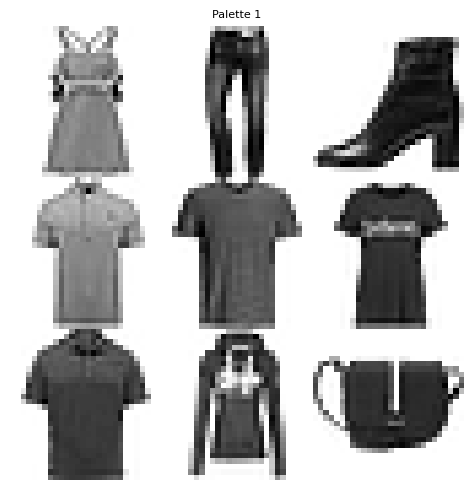

[['Dress' 'Trouser' 'Ankle boot']
 ['Shirt' 'T-shirt/top' 'T-shirt/top']
 ['T-shirt/top' 'Coat' 'Bag']]


In [23]:
palette1 = grids[0][0]
palette1_lb = grids[0][1]
palette1_img = create_palette(palette1)

plot_fmnist_grid([palette1_img], ["Palette 1"], n_rows=1, n_cols=1, figsize=(5, 5))
detected_classes1 = detect_classes(
    palette1_img, svm, detect_threshold=0.3, img_threshold=0.1
)
print(detected_classes1)


### Przykład 2

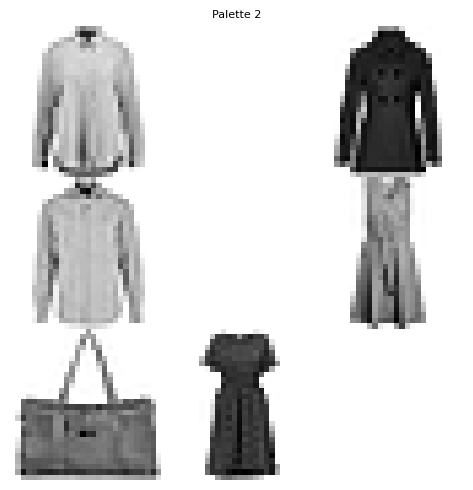

[['Empty' 'Empty' 'Coat']
 ['Shirt' 'Empty' 'Trouser']
 ['Bag' 'Dress' 'Empty']]


/tmp/ipykernel_9177/1434050666.py:9: RuntimeWarning: invalid value encountered in divide
  grad_mag = (grad_mag - grad_mag.min()) / (grad_mag.max() - grad_mag.min())  # norm
/tmp/ipykernel_9177/1434050666.py:9: RuntimeWarning: invalid value encountered in divide
  grad_mag = (grad_mag - grad_mag.min()) / (grad_mag.max() - grad_mag.min())  # norm
/tmp/ipykernel_9177/1434050666.py:9: RuntimeWarning: invalid value encountered in divide
  grad_mag = (grad_mag - grad_mag.min()) / (grad_mag.max() - grad_mag.min())  # norm


In [25]:
palette2 = grids[1][0]
palette2_img = create_palette(palette2)

plot_fmnist_grid([palette2_img], ["Palette 2"], n_rows=1, n_cols=1, figsize=(5, 5))
detected_classes2 = detect_classes(
    palette2_img, svm, detect_threshold=0.3, img_threshold=0.1
)
print(detected_classes2)


### Przykład 3

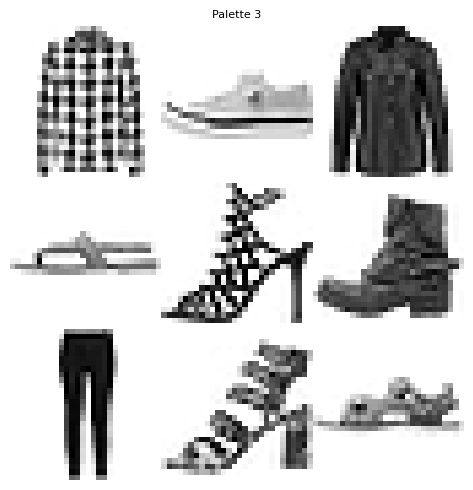

[['Shirt' 'Sneaker' 'Shirt']
 ['Sandal' 'Sandal' 'Ankle boot']
 ['Trouser' 'Sandal' 'Sneaker']]


In [28]:
palette3 = grids[2][0]
palette3_img = create_palette(palette3)

plot_fmnist_grid([palette3_img], ["Palette 3"], n_rows=1, n_cols=1, figsize=(5, 5))
detected_classes3 = detect_classes(
    palette3_img, svm, detect_threshold=0.3, img_threshold=0.1
)
print(detected_classes3)